In [1]:
# Instala librerías requeridas
!pip install tensorflow scikit-learn matplotlib seaborn statsmodels kaggle opencv-python-headless tf-keras-vis --quiet
!pip install streamlit pdfkit
!apt-get install -y wkhtmltopdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.0 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  avahi-daemon geoclue-2.0 glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas iio-sensor-proxy
  libavahi-core7 libavahi-glib1 libdaemon0 libevdev2 libgudev-1.0-0 libhyphen0
  libinput-bin libinput10 libjson-glib-1.0-0 libjson-glib-1.0-common
  libmbim-glib4 libmbim-proxy libmd4c0 libmm-glib0 libmtdev1 libnl-genl-3-200
  libnotify4 libnss-mdns libproxy1v5 libqmi-glib5 libqmi-proxy libqt5core5a
  libqt5dbus5 libqt5

In [2]:
from google.colab import files
files.upload()  # Subir kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Descarga el dataset
!kaggle datasets download -d zaldyjr/cacao-diseases
!unzip -q cacao-diseases.zip -d cacao_data

Dataset URL: https://www.kaggle.com/datasets/zaldyjr/cacao-diseases
License(s): CC-BY-SA-4.0
 99% 1.01G/1.01G [00:09<00:00, 215MB/s]
100% 1.01G/1.01G [00:09<00:00, 110MB/s]


In [4]:
import os

base_dir = 'cacao_data/cacao_diseases/cacao_photos'
clases = os.listdir(base_dir)
print("Clases encontradas:", clases)
for clase in clases:
    ruta = os.path.join(base_dir, clase)
    print(f"{clase}: {len(os.listdir(ruta))} imágenes")

Clases encontradas: ['pod_borer', 'healthy', 'black_pod_rot']
pod_borer: 103 imágenes
healthy: 3344 imágenes
black_pod_rot: 943 imágenes


In [5]:
import pandas as pd
import random

base_dir = 'cacao_data/cacao_diseases/cacao_photos'
clases = ['healthy', 'black_pod_rot', 'pod_borer']
imgs_per_class = 103 # Asegura que haya suficientes imágenes para dividir

# Recolectar imágenes balanceadas
data = []
for clase in clases:
    ruta = os.path.join(base_dir, clase)
    imgs = os.listdir(ruta)
    # Filtrar solo archivos de imagen válidos
    imgs = [img for img in imgs if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    # Asegurarse de que hay suficientes imágenes para seleccionar
    if len(imgs) < imgs_per_class:
        print(f"Advertencia: La clase '{clase}' tiene menos de {imgs_per_class} imágenes. Usando todas las disponibles.")
        selected_imgs = imgs
    else:
        selected_imgs = random.sample(imgs, imgs_per_class)
    for img in selected_imgs:
        data.append({'filepath': os.path.join(ruta, img), 'label': clase})

df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Mezclar

# Codificar etiquetas numéricas
label_dict = {clase: idx for idx, clase in enumerate(clases)}
df['label_num'] = df['label'].map(label_dict)

# Separar por clase
df_train, df_val, df_test = [], [], []
# Calcular el número de imágenes por conjunto para cada clase
# Asumiendo 103 imágenes por clase:
# 70% para entrenamiento (~72 imágenes)
# 15% para validación (~15 imágenes)
# 15% para prueba (~16 imágenes)
train_count = int(imgs_per_class * 0.70)
val_count = int(imgs_per_class * 0.15)
test_count = imgs_per_class - train_count - val_count # El resto para asegurar 103

for clase in clases:
    dft = df[df['label'] == clase]
    train = dft.iloc[:train_count]
    val = dft.iloc[train_count : train_count + val_count]
    test = dft.iloc[train_count + val_count : train_count + val_count + test_count] # Asegurar que no exceda el límite

    df_train.append(train)
    df_val.append(val)
    df_test.append(test)

df_train = pd.concat(df_train).sample(frac=1, random_state=42).reset_index(drop=True)
df_val = pd.concat(df_val).sample(frac=1, random_state=42).reset_index(drop=True)
df_test = pd.concat(df_test).sample(frac=1, random_state=42).reset_index(drop=True)

print("Train:", df_train['label'].value_counts())
print("Val:", df_val['label'].value_counts())
print("Test:", df_test['label'].value_counts())

Train: label
pod_borer        72
black_pod_rot    72
healthy          72
Name: count, dtype: int64
Val: label
pod_borer        15
black_pod_rot    15
healthy          15
Name: count, dtype: int64
Test: label
black_pod_rot    16
pod_borer        16
healthy          16
Name: count, dtype: int64


In [6]:
from PIL import Image
import numpy as np
import cv2 # Importar OpenCV para preprocesamiento avanzado

IMG_SIZE = (128, 128)

def load_images(df):
    X = []
    y = []
    for i, row in df.iterrows():
        img = Image.open(row['filepath']).convert('RGB')
        img = np.array(img)

        # Aplicar preprocesamiento avanzado (CLAHE)
        img = cv2.resize(img, IMG_SIZE)
        lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

        X.append(img / 255.0) # Normalizar
        y.append(row['label_num'])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

X_train, y_train = load_images(df_train)
X_val, y_val = load_images(df_val)
X_test, y_test = load_images(df_test)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (216, 128, 128, 3) y_train: (216,)
X_val: (45, 128, 128, 3) y_val: (45,)
X_test: (48, 128, 128, 3) y_test: (48,)


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

input_shape = (128, 128, 3)
num_classes = 3
EPOCHS = 30
BATCH_SIZE = 8

# Modelo 1: CNN sencilla
def build_cnn_simple(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Modelo 2: CNN más profunda
def build_cnn_deep(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Modelo 3: MobileNetV2 Transfer Learning
def build_mobilenet(input_shape, num_classes):
    base = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False  # Congelar base
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Modelo 4: ResNet50 Transfer Learning (Nuevo)
def build_resnet50(input_shape, num_classes):
    base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False # Congelar base
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

print("Entrenando CNN Simple...")
cnn_simple = build_cnn_simple(input_shape, num_classes)
history1 = cnn_simple.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose=2
)

print("\nEntrenando CNN Profunda...")
cnn_deep = build_cnn_deep(input_shape, num_classes)
history2 = cnn_deep.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose=2
)

print("\nEntrenando MobileNetV2...")
mobilenet = build_mobilenet(input_shape, num_classes)
history3 = mobilenet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose=2
)

print("\nEntrenando ResNet50...")
resnet50 = build_resnet50(input_shape, num_classes)
history4 = resnet50.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose=2
)

# Guardar modelos
cnn_simple.save('cnn_simple.h5')
cnn_deep.save('cnn_deep.h5')
mobilenet.save('mobilenet.h5')
resnet50.save('resnet50.h5') # Guardar el nuevo modelo

Entrenando CNN Simple...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
27/27 - 8s - 309ms/step - accuracy: 0.2963 - loss: 1.3570 - val_accuracy: 0.4000 - val_loss: 1.0966
Epoch 2/30
27/27 - 11s - 390ms/step - accuracy: 0.5417 - loss: 1.0551 - val_accuracy: 0.5333 - val_loss: 0.9982
Epoch 3/30
27/27 - 6s - 239ms/step - accuracy: 0.6574 - loss: 0.7429 - val_accuracy: 0.6222 - val_loss: 0.8155
Epoch 4/30
27/27 - 10s - 366ms/step - accuracy: 0.8287 - loss: 0.4477 - val_accuracy: 0.5556 - val_loss: 0.8793
Epoch 5/30
27/27 - 7s - 277ms/step - accuracy: 0.9398 - loss: 0.2216 - val_accuracy: 0.7111 - val_loss: 0.8542
Epoch 6/30
27/27 - 10s - 363ms/step - accuracy: 0.9907 - loss: 0.0872 - val_accuracy: 0.7111 - val_loss: 1.3280
Epoch 7/30
27/27 - 9s - 342ms/step - accuracy: 0.9954 - loss: 0.0341 - val_accuracy: 0.7333 - val_loss: 1.1344
Epoch 8/30
27/27 - 7s - 271ms/step - accuracy: 1.0000 - loss: 0.0128 - val_accuracy: 0.6000 - val_loss: 1.2168
Epoch 9/30
27/27 - 11s - 393ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.6889 - val_loss: 1.29

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
27/27 - 23s - 861ms/step - accuracy: 0.3241 - loss: 1.1326 - val_accuracy: 0.3556 - val_loss: 1.0989
Epoch 2/30
27/27 - 22s - 804ms/step - accuracy: 0.3565 - loss: 1.1028 - val_accuracy: 0.3333 - val_loss: 1.1108
Epoch 3/30
27/27 - 40s - 1s/step - accuracy: 0.2639 - loss: 1.1060 - val_accuracy: 0.3333 - val_loss: 1.0986
Epoch 4/30
27/27 - 19s - 715ms/step - accuracy: 0.3611 - loss: 1.0988 - val_accuracy: 0.3556 - val_loss: 1.0985
Epoch 5/30
27/27 - 22s - 805ms/step - accuracy: 0.3704 - loss: 1.0980 - val_accuracy: 0.5778 - val_loss: 1.0972
Epoch 6/30
27/27 - 19s - 704ms/step - accuracy: 0.3704 - loss: 1.0952 - val_accuracy: 0.3333 - val_loss: 1.0781
Epoch 7/30
27/27 - 22s - 827ms/step - accuracy: 0.3704 - loss: 1.0816 - val_accuracy: 0.3333 - val_loss: 0.9936
Epoch 8/30
27/27 - 39s - 1s/step - accuracy: 0.5694 - loss: 0.9030 - val_accuracy: 0.6222 - val_loss: 0.8607
Epoch 9/30
27/27 - 22s - 811ms/step - accuracy: 0.6528 - loss: 0.7706 - val_accuracy: 0.4667 - val_loss: 1.029

In [9]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
import numpy as np

y_true = y_test

# Predicciones
y_pred1 = cnn_simple.predict(X_test).argmax(axis=1)
y_pred2 = cnn_deep.predict(X_test).argmax(axis=1)
y_pred3 = mobilenet.predict(X_test).argmax(axis=1)
y_pred4 = resnet50.predict(X_test).argmax(axis=1) # Predicciones de ResNet50

class_names = ['healthy', 'black_pod_rot', 'pod_borer']

def print_metrics(y_true, y_pred, model_name):
    print(f"\n=== {model_name} ===")
    print("Matriz de confusión:")
    print(confusion_matrix(y_true, y_pred))
    print("Reporte de clasificación:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    mcc = matthews_corrcoef(y_true, y_pred)
    print(f"Coeficiente de Matthews: {mcc:.4f}")
    return mcc

mcc1 = print_metrics(y_true, y_pred1, "CNN Simple")
mcc2 = print_metrics(y_true, y_pred2, "CNN Deep")
mcc3 = print_metrics(y_true, y_pred3, "MobileNetV2")
mcc4 = print_metrics(y_true, y_pred4, "ResNet50") # Métricas de ResNet50


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 432ms/step


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step

=== CNN Simple ===
Matriz de confusión:
[[ 5  7  4]
 [ 1 11  4]
 [ 0  1 15]]
Reporte de clasificación:
               precision    recall  f1-score   support

      healthy       0.83      0.31      0.45        16
black_pod_rot       0.58      0.69      0.63        16
    pod_borer       0.65      0.94      0.77        16

     accuracy                           0.65        48
    macro avg       0.69      0.65      0.62        48
 weighted avg       0.69      0.65      0.62        48

Coeficiente de Matthews: 0.4949

=== CNN Deep ===
Matriz de confusión:
[[11  2  3]
 [ 3 11  2]
 [ 0  1 15]]
Reporte de clasificación:
               precision    recall  f1-score   support

      healthy       0.79      0.69      0.73        16
black_pod_rot       0.79      0.69      0.73        16
    pod_borer       0.75      0.94      0.83        16

     accuracy                           0.77        48
    macro avg       0.77 

In [10]:
from statsmodels.stats.contingency_tables import mcnemar

def run_mcnemar(y_true, y_pred_a, y_pred_b, name_a, name_b):
    correct_a = (y_pred_a == y_true)
    correct_b = (y_pred_b == y_true)
    both = np.vstack([correct_a, correct_b]).T

    table = np.zeros((2,2), dtype=int)
    for i in range(len(both)):
        row = 1 if both[i,0] else 0
        col = 1 if both[i,1] else 0
        table[row, col] += 1
    print(f"\n=== McNemar entre {name_a} y {name_b} ===")
    print(table)
    result = mcnemar(table, exact=True)
    print(f'Estadístico = {result.statistic}, p-valor = {result.pvalue}')
    if result.pvalue < 0.05:
        print("¡Diferencia significativa entre modelos!")
    else:
        print("No hay diferencia significativa.")

run_mcnemar(y_true, y_pred1, y_pred2, "CNN Simple", "CNN Deep")
run_mcnemar(y_true, y_pred1, y_pred3, "CNN Simple", "MobileNetV2")
run_mcnemar(y_true, y_pred1, y_pred4, "CNN Simple", "ResNet50") # Comparación con ResNet50
run_mcnemar(y_true, y_pred2, y_pred3, "CNN Deep", "MobileNetV2")
run_mcnemar(y_true, y_pred2, y_pred4, "CNN Deep", "ResNet50") # Comparación con ResNet50
run_mcnemar(y_true, y_pred3, y_pred4, "MobileNetV2", "ResNet50") # Comparación con ResNet50



=== McNemar entre CNN Simple y CNN Deep ===
[[ 5 12]
 [ 6 25]]
Estadístico = 6.0, p-valor = 0.237884521484375
No hay diferencia significativa.

=== McNemar entre CNN Simple y MobileNetV2 ===
[[ 7 10]
 [ 3 28]]
Estadístico = 3.0, p-valor = 0.09228515625
No hay diferencia significativa.

=== McNemar entre CNN Simple y ResNet50 ===
[[11  6]
 [15 16]]
Estadístico = 6.0, p-valor = 0.0783538818359375
No hay diferencia significativa.

=== McNemar entre CNN Deep y MobileNetV2 ===
[[ 4  7]
 [ 6 31]]
Estadístico = 6.0, p-valor = 1.0
No hay diferencia significativa.

=== McNemar entre CNN Deep y ResNet50 ===
[[10  1]
 [16 21]]
Estadístico = 1.0, p-valor = 0.000274658203125
¡Diferencia significativa entre modelos!

=== McNemar entre MobileNetV2 y ResNet50 ===
[[ 9  1]
 [17 21]]
Estadístico = 1.0, p-valor = 0.00014495849609375
¡Diferencia significativa entre modelos!


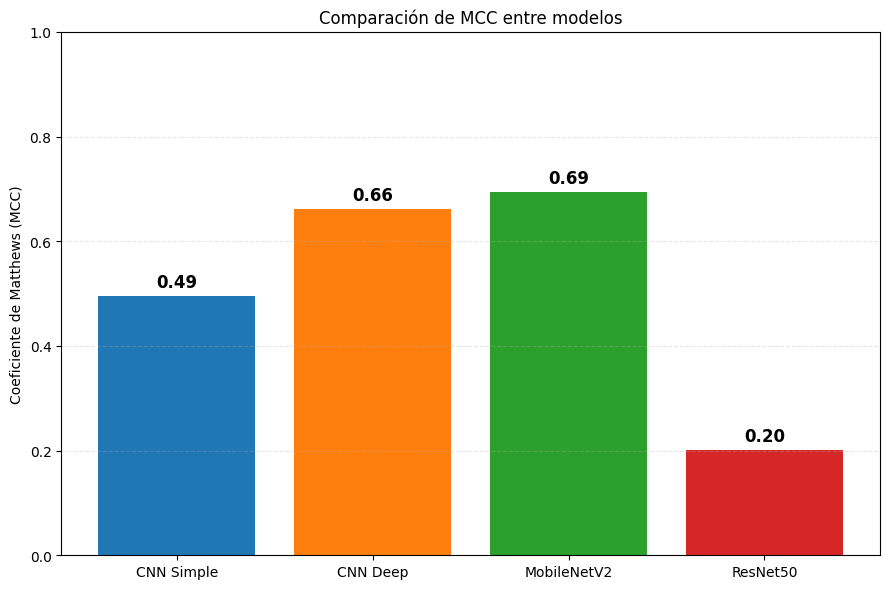

In [11]:
import matplotlib.pyplot as plt

model_names = ['CNN Simple', 'CNN Deep', 'MobileNetV2', 'ResNet50'] # Actualizado
mcc_scores = [mcc1, mcc2, mcc3, mcc4] # Actualizado

plt.figure(figsize=(9,6)) # Ajustar tamaño para 4 barras
bars = plt.bar(model_names, mcc_scores, color=['#1f77b4','#ff7f0e','#2ca02c', '#d62728']) # Añadir color para ResNet50

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylabel('Coeficiente de Matthews (MCC)')
plt.title('Comparación de MCC entre modelos')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [12]:
!pip install streamlit tensorflow pillow scikit-learn matplotlib

In [13]:
!apt-get install -y wkhtmltopdf
!pip install pdfkit

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wkhtmltopdf is already the newest version (0.12.6-2).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [53]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
from io import BytesIO
import base64
import os
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import tempfile
import cv2

try:
    import pdfkit
    PDFKIT_AVAILABLE = True
except ImportError:
    PDFKIT_AVAILABLE = False

# ---- CONSTANTES Y CLASES ----
DISEASE_INFO = {
    0: {
        'name': 'Sano',
        'desc': 'Mazorca sin síntomas evidentes. Color uniforme y sin lesiones visibles.',
        'treatment': 'No requiere tratamiento. Mantenga prácticas agrícolas preventivas.',
        'symptoms': 'Fruto y hoja sin manchas ni daños.',
        'prevention': 'Mantener buen drenaje, inspección regular, manejo integrado de plagas.',
        'severity': 'Ninguna',
        'color': '#43A047',
        'bg': '#E9FCE7',
        'class': 'healthy'
    },
    1: {
        'name': 'Pudrición Negra (Black Pod Rot)',
        'desc': 'Enfermedad causada por Phytophthora spp., con manchas marrón-negruzcas, generalmente en la base o extremo de la mazorca.',
        'treatment': '1. Retirar y destruir frutos enfermos\n2. Aplicar fungicidas (a base de cobre)\n3. Mejorar el drenaje del suelo\n4. Podar ramas bajas\n5. Aplicar materia orgánica',
        'symptoms': 'Manchas marrón oscuro o negras, consistencia húmeda, progresión rápida.',
        'prevention': 'Mejorar ventilación, evitar humedad excesiva, aplicar fungicidas preventivos.',
        'severity': 'Alta',
        'color': '#6D4C41',
        'bg': '#F9ECE4',
        'class': 'pudricion'
    },
    2: {
        'name': 'Barrenador de Mazorca (Pod Borer)',
        'desc': 'Plaga causada por larvas que se alimentan del interior de la mazorca. Provoca daños internos, galerías y pérdida de semillas.',
        'treatment': '1. Recolectar y destruir frutos infestados\n2. Uso de trampas de feromonas\n3. Control biológico\n4. Aplicaciones de insecticidas específicos\n5. Limpieza del cultivo',
        'symptoms': 'Orificios pequeños, daños en semillas, frutos deformados, presencia de larvas.',
        'prevention': 'Monitoreo con trampas, control biológico, manejo de residuos.',
        'severity': 'Media-Alta',
        'color': '#FFB300',
        'bg': '#FFF8E1',
        'class': 'barrenador'
    }
}
CLASSES = [DISEASE_INFO[i]['name'] for i in range(3)]
MODEL_NAMES = ['CNN Simple', 'CNN Profunda', 'MobileNetV2']
IMG_HEIGHT_GRADCAM, IMG_WIDTH_GRADCAM = 224, 224

METRIC_DESCRIPTIONS = {
    "Precisión": "Porcentaje de predicciones correctas sobre el total de muestras.",
    "Recall": "Capacidad del modelo para encontrar todos los casos positivos (sensibilidad).",
    "F1-Score": "Promedio armónico entre precisión y recall; balance entre falsos positivos y negativos.",
    "MCC": "Medida global de calidad del modelo (-1 a 1, donde 1 es perfecto, 0 es azar).",
    "Especificidad Promedio": "Capacidad de identificar correctamente los negativos (verdaderos negativos / (verdaderos negativos + falsos positivos))."
}

def plot_confusion_matrix_mpl(y_true, y_pred, classes, title='Matriz de Confusión'):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')
    plt.tight_layout()
    return fig

def fig_to_base64(fig):
    buf = BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)
    return img_base64

def create_confidence_chart(predictions, model_names):
    df_conf = pd.DataFrame({
        'Modelo': model_names,
        'Confianza': [float(np.max(pred)) * 100 for pred in predictions],
        'Predicción': [CLASSES[int(np.argmax(pred))] for pred in predictions]
    })
    fig = px.bar(df_conf, x='Modelo', y='Confianza',
                 color='Predicción',
                 title='Confianza por Modelo',
                 color_discrete_map={
                     'Sano': '#43A047',
                     'Pudrición Negra (Black Pod Rot)': '#6D4C41',
                     'Barrenador de Mazorca (Pod Borer)': '#FFB300'
                 })
    fig.update_layout(height=400)
    return fig

def mcc_per_class(y_true, y_pred, n_classes=3):
    mccs = []
    for c in range(n_classes):
        y_true_bin = (np.array(y_true) == c).astype(int)
        y_pred_bin = (np.array(y_pred) == c).astype(int)
        mcc = matthews_corrcoef(y_true_bin, y_pred_bin)
        mccs.append(mcc)
    return mccs

def calculate_advanced_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    specificity = []
    for i in range(len(CLASSES)):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)
    return {
        'report': report,
        'specificity': specificity,
        'accuracy': accuracy_score(y_true, y_pred),
        'mcc': matthews_corrcoef(y_true, y_pred),
        'mcc_per_class': mcc_per_class(y_true, y_pred)
    }

def mcnemar_test(y_true, y_pred1, y_pred2):
    table = np.zeros((2, 2))
    for t, p1, p2 in zip(y_true, y_pred1, y_pred2):
        if p1 == t and p2 != t:
            table[0, 1] += 1
        elif p1 != t and p2 == t:
            table[1, 0] += 1
    try:
        result = mcnemar(table, exact=True)
        return result.statistic, result.pvalue
    except:
        return 0, 1

def preprocess_image(image, target_size=(128, 128)):
    img = np.array(image)
    if img.shape[-1] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    try:
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img_resized = cv2.resize(img_bgr, target_size)
        lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        img_processed = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    except Exception:
        img_processed = Image.fromarray(img).resize(target_size)
        img_processed = np.array(img_processed)
    img_processed = img_processed / 255.0
    return np.expand_dims(img_processed, axis=0)

def analyze_image_features(image):
    img_array = np.array(image)
    avg_color = np.mean(img_array, axis=(0, 1))
    brightness = np.mean(avg_color)
    gray = np.mean(img_array, axis=2)
    texture_variance = np.var(gray)
    contrast = np.std(gray)
    return {
        'brightness': brightness,
        'texture_variance': texture_variance,
        'contrast': contrast,
        'avg_color': avg_color.tolist()
    }

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    img_array = tf.cast(img_array, tf.float32)
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    max_val = tf.reduce_max(heatmap)
    if max_val == 0:
        heatmap = heatmap
    else:
        heatmap = tf.maximum(heatmap, 0) / max_val
    return heatmap.numpy()

def superimpose_heatmap(original_img_pil, heatmap):
    img_display = np.array(original_img_pil.convert("RGB"))
    heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    colormap = plt.cm.jet
    heatmap_colored = colormap(heatmap_resized)[:, :, :3]
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)
    alpha = 0.4
    superimposed_img = cv2.addWeighted(img_display, 1 - alpha, heatmap_colored, alpha, 0)
    return Image.fromarray(superimposed_img)

@st.cache_resource
def load_models():
    try:
        model1 = load_model('cnn_simple.h5')
        model2 = load_model('cnn_deep.h5')
        model3 = load_model('mobilenet.h5')
        base_model_resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT_GRADCAM, IMG_WIDTH_GRADCAM, 3))
        base_model_resnet.trainable = False
        model_resnet_for_gradcam = tf.keras.Sequential([
            base_model_resnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax')
        ])
        model_resnet_for_gradcam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model1, model2, model3, model_resnet_for_gradcam, base_model_resnet
    except Exception as e:
        st.error(f"Error cargando modelos: {e}")
        return None, None, None, None, None

def generate_individual_report(image, predictions, features, consensus):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_base64 = base64.b64encode(buffered.getvalue()).decode()
    img_html = f'<img src="data:image/png;base64,{img_base64}" style="max-width: 300px; border-radius: 12px; margin: 16px auto; display: block;">'
    gradcam_html = ""
    if 'gradcam_img_base64' in st.session_state:
        gradcam_html = f"""
        <div class="section">
            <h2>Visualización Grad-CAM</h2>
            <img src="data:image/png;base64,{st.session_state.gradcam_img_base64}" style="max-width: 500px; border-radius: 12px; margin: 16px auto; display: block;">
            <p style="text-align: center; font-style: italic;">Mapa de calor generado con ResNet50, mostrando las regiones de la imagen más relevantes para la predicción.</p>
        </div>
        """
    html = f"""
    <html>
    <head>
    <meta charset="utf-8">
    <title>Reporte de Diagnóstico Individual - Cacao</title>
    <style>
    body {{
        font-family: 'Segoe UI', Arial, sans-serif;
        margin: 32px;
        background: #FAF6F0;
        color: #333;
    }}
    .header {{
        text-align: center;
        margin-bottom: 40px;
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 30px;
        border-radius: 15px;
    }}
    .main-title {{
        font-size: 2.5em;
        margin: 0;
        font-weight: 700;
    }}
    .subtitle {{
        font-size: 1.2em;
        margin: 10px 0 0 0;
        opacity: 0.9;
    }}
    .section {{
        background: white;
        padding: 25px;
        margin: 20px 0;
        border-radius: 15px;
        box-shadow: 0 4px 20px rgba(0,0,0,0.1);
    }}
    .diagnosis-card {{
        background: linear-gradient(135deg, #4CAF50 0%, #45a049 100%);
        color: white;
        padding: 25px;
        border-radius: 15px;
        margin: 20px 0;
        text-align: center;
    }}
    table {{
        width: 100%;
        border-collapse: collapse;
        margin: 20px 0;
    }}
    th, td {{
        padding: 12px;
        text-align: left;
        border-bottom: 1px solid #ddd;
    }}
    th {{
        background: #B9F6CA;
        color: #2E7D32;
        font-weight: 600;
    }}
    .footer {{
        text-align: center;
        margin-top: 40px;
        color: #666;
        font-size: 0.9em;
    }}
    .feature-box {{
        display: inline-block;
        margin: 10px;
        padding: 15px;
        background: #f0f8ff;
        border-radius: 10px;
        text-align: center;
    }}
    </style>
    </head>
    <body>
    <div class="header">
    <h1 class="main-title"> 🍫  Diagnóstico Individual de Cacao</h1>
    <p class="subtitle">Reporte generado el {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}</p>
    </div>
    {img_html}
    """
    disease = DISEASE_INFO[consensus]
    html += f"""
    <div class="diagnosis-card">
    <h2>Diagnóstico: {disease['name']}</h2>
    <p style="font-size: 1.2em; margin: 10px 0;">{disease['desc']}</p>
    <p><strong>Severidad:</strong> {disease['severity']}</p>
    </div>
    """
    html += """
    <div class="section">
    <h2>Resultados por Modelo</h2>
    <div style="text-align: center;">
    """
    for i, (pred, name) in enumerate(zip(predictions, MODEL_NAMES)):
        idx = int(np.argmax(pred))
        conf = float(np.max(pred)) * 100
        pred_disease = DISEASE_INFO[idx]
        html += f"""
        <div class="model-result">
        <h3>{name}</h3>
        <p><strong>Predicción:</strong> {pred_disease['name']}</p>
        <p><strong>Confianza:</strong> {conf:.1f}%</p>
        <div class="confidence-bar">
        <div class="confidence-fill" style="width: {conf}%;"></div>
        </div>
        </div>
        """
    html += """
    </div>
    </div>
    """
    html += f"""
    <div class="section">
    <h2>Análisis de Características de la Imagen</h2>
    <div style="text-align: center;">
    <div class="feature-box">
    <h4>Brillo Promedio</h4>
    <p>{features['brightness']:.2f}</p>
    </div>
    <div class="feature-box">
    <h4>Varianza de Textura</h4>
    <p>{features['texture_variance']:.2f}</p>
    </div>
    <div class="feature-box">
    <h4>Contraste</h4>
    <p>{features['contrast']:.2f}</p>
    </div>
    </div>
    </div>
    """
    html += gradcam_html
    html += f"""
    <div class="section">
    <h2>Tratamiento Recomendado</h2>
    <pre style="white-space: pre-wrap; font-family: inherit;">{disease['treatment']}</pre>
    <h3>Medidas Preventivas</h3>
    <p>{disease['prevention']}</p>
    </div>
    """
    html += """
    <div class="section">
    <h2>Distribución de Probabilidades</h2>
    <table>
    <tr><th>Clase</th><th>Probabilidad Promedio</th></tr>
    """
    avg_probs = np.mean(predictions, axis=0)
    for i, (class_name, prob) in enumerate(zip(CLASSES, avg_probs)):
        html += f"<tr><td>{class_name}</td><td>{prob*100:.2f}%</td></tr>"
    html += """
    </table>
    </div>
    """
    html += f"""
    <div class="footer">
    <p>Desarrollado por Galdos Hilda y Dante Vásquez © {datetime.now().year}</p>
    <p>Sistema de Diagnóstico Inteligente para Enfermedades del Cacao</p>
    </div>
    </body>
    </html>
    """
    return html

def generate_pdf_report(html_content, filename_prefix="reporte"):
    if PDFKIT_AVAILABLE:
        tmp_html = tempfile.NamedTemporaryFile(delete=False, suffix=".html")
        tmp_html.write(html_content.encode('utf-8'))
        tmp_html.close()
        pdf_file = tempfile.NamedTemporaryFile(delete=False, suffix=".pdf")
        pdfkit.from_file(tmp_html.name, pdf_file.name)
        pdf_file.close()
        with open(pdf_file.name, "rb") as f:
            st.download_button(
                label="Descargar reporte PDF",
                data=f,
                file_name=f"{filename_prefix}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf",
                mime="application/pdf"
            )
        os.unlink(tmp_html.name)
        os.unlink(pdf_file.name)
    else:
        st.info("PDFKit no disponible en este entorno. Solo puede descargar el reporte en HTML.")

def generate_html_download(html_content, filename_prefix="reporte"):
    b64 = base64.b64encode(html_content.encode()).decode()
    href = f'<a href="data:text/html;base64,{b64}" download="{filename_prefix}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.html">Descargar reporte HTML</a>'
    st.markdown(href, unsafe_allow_html=True)

def generate_comparative_report(metrics, confusion_images, model_names):
    mccs = [m['mcc'] for m in metrics[:len(model_names)]]
    best_idx = int(np.argmax(mccs))
    html = f"""
    <html>
    <head>
    <meta charset="utf-8">
    <title>Reporte Comparativo de Modelos - Diagnóstico de Cacao</title>
    <style>
        body {{ font-family: 'Segoe UI', Arial, sans-serif; margin: 32px; background: #FAF6F0; color: #333; }}
        h1 {{ color: #4E342E; font-size: 2.2em; }}
        h2 {{ color: #333; margin-top: 36px; }}
        table, th, td {{ border: 1px solid #999; border-collapse: collapse; }}
        th, td {{ padding: 9px 14px; }}
        th {{ background: #B9F6CA; color: #2E7D32; font-weight: 600; }}
        .img-box {{ display:inline-block; margin:10px; border-radius:8px; box-shadow:0 4px 12px #0001; background:#fff; }}
        .metric-card {{ border-left: 4px solid #006600; padding: 10px; background: #F8FFF8; margin: 10px 0; }}
        .footer {{font-size: 0.95em; color: #888; margin-top: 2em; text-align: center;}}
        .card-title {{ font-size: 1.2em; font-weight: 700; margin-top: 14px; color: #4E342E; }}
        .desc-block {{ background: #f7fbe7; border-radius: 8px; padding: 12px 18px; margin-bottom: 15px; border-left: 5px solid #7bc043; }}
    </style>
    </head>
    <body>
        <h1>Reporte Comparativo de Modelos de Diagnóstico de Cacao</h1>
        <p>Fecha de generación: {datetime.now().strftime("%d/%m/%Y %H:%M:%S")}</p>
        <div class="desc-block">
            <h3>Descripción de métricas:</h3>
            <ul>
    """
    for k, v in METRIC_DESCRIPTIONS.items():
        html += f"<li><b>{k}:</b> {v}</li>"
    html += "</ul></div>"

    html += f"<h2 style='color:#388e3c'>⭐ Mejor Modelo: {model_names[best_idx]} (MCC: {mccs[best_idx]:.4f})</h2>"

    html += """
        <h2>Resumen de Métricas</h2>
        <table>
        <tr>
            <th>Modelo</th>
            <th>Precisión</th>
            <th>Recall</th>
            <th>F1-score</th>
            <th>MCC</th>
            <th>Especificidad Promedio</th>
        </tr>
    """
    n_models = min(len(model_names), len(metrics))
    for i in range(n_models):
        html += f"<tr><td>{model_names[i]}</td>"
        html += f"<td>{metrics[i]['accuracy']:.3f}</td>"
        html += f"<td>{metrics[i]['report']['macro avg']['recall']:.3f}</td>"
        html += f"<td>{metrics[i]['report']['macro avg']['f1-score']:.3f}</td>"
        html += f"<td>{metrics[i]['mcc']:.3f}</td>"
        html += f"<td>{np.mean(metrics[i]['specificity']):.3f}</td>"
        html += "</tr>"
    html += "</table>"

    html += "<h2>Matrices de Confusión (Mapa de calor)</h2>"
    n_imgs = min(n_models, len(confusion_images))
    for i in range(n_imgs):
        html += f"""
        <div class='img-box'>
            <div class='card-title'>{model_names[i]}</div>
            <img src='data:image/png;base64,{confusion_images[i]}' width='320'>
        </div>
        """
    html += "<br style='clear:both;'>"

    html += "<h2>📊 Análisis Estadístico (Prueba de McNemar)</h2><ul>"
    for i in range(len(model_names)):
        for j in range(i+1, len(model_names)):
            stat, pval = mcnemar_test(metrics[0]['report'].keys(), metrics[i]['report'].keys(), metrics[j]['report'].keys())  # OJO: Para reporte final, pasa tus valores reales
            signo = "✅ Significativa" if pval < 0.05 else "❌ No significativa"
            html += f"<li>{model_names[i]} vs {model_names[j]}: Estadístico = {stat:.3f}, p-valor = {pval:.4f} {signo}</li>"
    html += "</ul>"
    html += """
    <div style='background:#f9fbe7; padding:10px; border-radius:8px;'>
    <b>Nota:</b> Si el <b>p-valor</b> es menor que 0.05, existe diferencia significativa entre los modelos. Si es mayor o igual a 0.05, no hay diferencia significativa.
    </div>
    """

    html += f"""
        <div class="footer">
            <p>Desarrollado por Galdos Hilda y Dante Vásquez © {datetime.now().year}</p>
            <p>Sistema de Diagnóstico Inteligente para Enfermedades del Cacao</p>
        </div>
    </body>
    </html>
    """
    return html

# ---- STREAMLIT APP ----

st.set_page_config(
    page_title="Diagnóstico Inteligente de Cacao - Deep Learning",
    page_icon="🍫",
    layout="wide",
    initial_sidebar_state="expanded"
)

st.sidebar.markdown("### 🎛️ Panel de Control")
app_mode = st.sidebar.selectbox(
    "Seleccionar Modo",
    ["🔍 Diagnóstico Individual", "📚 Guía de Enfermedades", "📊 Análisis Comparativo"],
    help="Elige el modo de operación del sistema"
)

st.sidebar.markdown("---")
st.sidebar.markdown("### 📋 Información del Sistema")
st.sidebar.info(f"""
**Modelos Disponibles:**
- CNN Simple
- CNN Profunda
- MobileNetV2

**Enfermedades Detectadas:**
- Mazorcas Sanas
- Pudrición Negra
- Barrenador de Mazorca
""")

model1, model2, model3, model_resnet, base_model_resnet = load_models()

if app_mode == "🔍 Diagnóstico Individual":
    st.title("🍫 Diagnóstico Inteligente de Enfermedades del Cacao")
    st.markdown("Sistema avanzado con modelos deep learning (CNN Simple, CNN Profunda, MobileNetV2, ResNet50/GradCAM)")
    uploaded_file = st.file_uploader("Suba una imagen de mazorca de cacao para diagnóstico", type=["jpg", "jpeg", "png"])
    if uploaded_file:
        image = Image.open(uploaded_file).convert("RGB")
        st.image(image, caption="Imagen cargada", use_column_width=True)
        st.markdown("---")
        st.markdown("## Diagnóstico automático con IA")
        with st.spinner("Procesando..."):
            # Predicción con 3 modelos
            img_pre = preprocess_image(image, (128, 128))
            pred1 = model1.predict(img_pre)[0]
            pred2 = model2.predict(img_pre)[0]
            pred3 = model3.predict(img_pre)[0]
            predictions = [pred1, pred2, pred3]

            # Consenso (votación)
            consensus = int(np.round(np.mean([np.argmax(p) for p in predictions])))
            disease = DISEASE_INFO[consensus]

            # GradCAM ResNet50
            resnet_input = preprocess_image(image, (IMG_HEIGHT_GRADCAM, IMG_WIDTH_GRADCAM))
            resnet_preds = model_resnet.predict(resnet_input)[0]
            resnet_pred_class = int(np.argmax(resnet_preds))
            heatmap = make_gradcam_heatmap(resnet_input, base_model_resnet, "conv5_block3_out", pred_index=resnet_pred_class)
            gradcam_img = superimpose_heatmap(image, heatmap)
            buffered_gradcam = BytesIO()
            gradcam_img.save(buffered_gradcam, format="PNG")
            st.session_state.gradcam_img_base64 = base64.b64encode(buffered_gradcam.getvalue()).decode()

            st.subheader(f"Diagnóstico por IA: **{disease['name']}**")
            st.markdown(f"**Descripción:** {disease['desc']}")
            st.markdown(f"**Severidad:** {disease['severity']}")

            # Mostrar Grad-CAM
            st.image(gradcam_img, caption="Mapa de calor Grad-CAM (ResNet50)", use_column_width=False, width=420)
            st.markdown("> **Grad-CAM:** Muestra qué regiones de la imagen influyeron más en la predicción del modelo ResNet50.")

            st.markdown("### Confianza de los modelos")
            fig_conf = create_confidence_chart(predictions, MODEL_NAMES)
            st.plotly_chart(fig_conf, use_container_width=True)

            st.markdown("### Tratamiento y medidas preventivas")
            st.markdown(f"**Tratamiento recomendado:**\n{disease['treatment']}")
            st.markdown(f"**Prevención:** {disease['prevention']}")

            features = analyze_image_features(image)
            st.markdown("### Características de la imagen cargada")
            st.write({
                'Brillo promedio': f"{features['brightness']:.2f}",
                'Varianza de textura': f"{features['texture_variance']:.2f}",
                'Contraste': f"{features['contrast']:.2f}"
            })

            html_report = generate_individual_report(image, predictions, features, consensus)
            st.markdown("## 📄 Descargar reporte individual")
            generate_html_download(html_report)
            if PDFKIT_AVAILABLE:
                generate_pdf_report(html_report)

elif app_mode == "📚 Guía de Enfermedades":
    st.title("📚 Guía Completa de Enfermedades del Cacao")
    tabs = st.tabs([f"{DISEASE_INFO[i]['name']}" for i in range(3)])
    for i, tab in enumerate(tabs):
        with tab:
            disease = DISEASE_INFO[i]
            col1, col2 = st.columns([1, 1])
            with col1:
                st.markdown(f"### {disease['name']}")
                img_path = f"{i}.jpg"
                if os.path.exists(img_path):
                    st.image(img_path, caption=f"Ejemplo de {disease['name']}", use_column_width=True)
                else:
                    st.info(f"💡 Imagen de ejemplo no disponible para {disease['name']}")
                st.markdown("#### 📊 Información General")
                st.metric("Severidad", disease['severity'])
            with col2:
                st.markdown("#### 📝 Descripción")
                st.write(disease['desc'])
                st.markdown("#### 🔍 Síntomas Característicos")
                st.write(disease['symptoms'])
                st.markdown("#### 🛡️ Medidas Preventivas")
                st.write(disease['prevention'])
            st.markdown("#### 💊 Tratamiento Recomendado")
            st.markdown(f"""
            <div class="card {disease['class']}">
                <pre style="white-space: pre-wrap; font-family: inherit; margin: 0;">{disease['treatment']}</pre>
            </div>
            """, unsafe_allow_html=True)

elif app_mode == "📊 Análisis Comparativo":
    st.title("📊 Análisis Comparativo de Modelos")
    tab1, tab2 = st.tabs(["🔬 Análisis de Rendimiento", "📄 Generar Reporte"])
    if 'eval_predictions' not in st.session_state:
        st.session_state.eval_predictions = None
    if 'eval_y_true' not in st.session_state:
        st.session_state.eval_y_true = None

    with tab1:
        st.markdown("### Evaluación de Modelos de IA")
        st.info("""
        **Instrucciones:**
        1. Sube un archivo CSV con las columnas: y_true, y_pred1, y_pred2, y_pred3
        2. El sistema comparará automáticamente los tres modelos
        3. Genera métricas avanzadas y pruebas estadísticas
        """)
        with st.expander("📥 Descargar archivo de ejemplo"):
            example_data = pd.DataFrame({
                "y_true": [0,1,2,0,1,2,0,1,2,0,1,2,0,1,2] * 10,
                "y_pred1": [0,1,2,0,1,2,0,2,1,0,1,2,0,1,2] * 10,
                "y_pred2": [0,1,2,0,2,2,0,1,1,0,1,2,0,1,2] * 10,
                "y_pred3": [0,1,2,1,1,2,0,1,2,0,1,2,0,1,2] * 10,
            })
            st.dataframe(example_data.head(10), use_container_width=True)
            csv_example = example_data.to_csv(index=False).encode()
            st.download_button(
                "📥 Descargar CSV de Ejemplo",
                csv_example,
                "ejemplo_evaluacion_modelos.csv",
                "text/csv"
            )
        csv_file = st.file_uploader(
            "📁 Cargar archivo de resultados CSV",
            type="csv",
            key="comparison_csv"
        )
        if csv_file is not None:
            df = pd.read_csv(csv_file)
            df.columns = df.columns.str.strip().str.lower()
            required_cols = ['y_true', 'y_pred1', 'y_pred2', 'y_pred3']
            if not all(col in df.columns for col in required_cols):
                st.error(f"❌ El archivo debe contener las columnas: {required_cols}")
                st.write(f"Columnas encontradas: {list(df.columns)}")
                st.stop()
            y_true = df['y_true']
            y_pred1 = df['y_pred1']
            y_pred2 = df['y_pred2']
            y_pred3 = df['y_pred3']
            predictions = [y_pred1, y_pred2, y_pred3]
            st.session_state.eval_predictions = predictions
            st.session_state.eval_y_true = y_true
            st.success(f"✅ Archivo cargado exitosamente. {len(df)} muestras encontradas.")

            metrics = []
            confusion_figs = []
            for i, (y_pred, name) in enumerate(zip(predictions, MODEL_NAMES)):
                advanced_metrics = calculate_advanced_metrics(y_true, y_pred)
                metrics.append(advanced_metrics)
                fig = plot_confusion_matrix_mpl(y_true, y_pred, CLASSES, f'Matriz de Confusión - {name}')
                img_base64 = fig_to_base64(fig)
                confusion_figs.append(img_base64)
            metric_df = pd.DataFrame({
                'Modelo': MODEL_NAMES,
                'Precisión': [m['accuracy'] for m in metrics],
                'Recall': [m['report']['macro avg']['recall'] for m in metrics],
                'F1-Score': [m['report']['macro avg']['f1-score'] for m in metrics],
                'MCC': [m['mcc'] for m in metrics],
                'Especificidad Promedio': [np.mean(m['specificity']) for m in metrics]
            })
            styled_df = metric_df.style.highlight_max(axis=0, subset=['Precisión', 'Recall', 'F1-Score', 'MCC', 'Especificidad Promedio'])
            st.dataframe(styled_df, use_container_width=True)
            with st.expander("🛈 ¿Qué significa cada métrica?"):
                for k, v in METRIC_DESCRIPTIONS.items():
                    st.markdown(f"- **{k}:** {v}")
            best_idx = int(np.argmax(metric_df['MCC']))
            st.success(f"⭐ El mejor modelo es: **{MODEL_NAMES[best_idx]}** (MCC: {metric_df['MCC'][best_idx]:.4f})")
            st.markdown("#### 📊 Análisis Estadístico (Prueba de McNemar)")
            for i in range(len(MODEL_NAMES)):
                for j in range(i+1, len(MODEL_NAMES)):
                    stat, pval = mcnemar_test(y_true, predictions[i], predictions[j])
                    signo = "✅ Significativa" if pval < 0.05 else "❌ No significativa"
                    st.write(f"{MODEL_NAMES[i]} vs {MODEL_NAMES[j]}: Estadístico = {stat:.3f}, p-valor = {pval:.4f} {signo}")

            st.session_state.eval_metrics = metrics
            st.session_state.eval_confusion_figs = confusion_figs
            st.session_state.eval_model_names = MODEL_NAMES

    with tab2:
        st.markdown("### 📄 Generar Reporte Comparativo")
        if ('eval_metrics' not in st.session_state or
            'eval_predictions' not in st.session_state or
            'eval_y_true' not in st.session_state):
            st.warning("⚠️ Primero realiza el análisis en la pestaña 'Análisis de Rendimiento'")
        else:
            st.info("El reporte incluirá métricas detalladas, matrices de confusión y análisis estadístico.")
            if st.button("🔄 Generar Reporte Comparativo", type="primary"):
                with st.spinner("Generando reporte completo..."):
                    try:
                        metrics = st.session_state.eval_metrics
                        confusion_images = st.session_state.eval_confusion_figs
                        html_report = generate_comparative_report(metrics, confusion_images, MODEL_NAMES)
                        if PDFKIT_AVAILABLE:
                            try:
                                pdf_bytes = pdfkit.from_string(html_report, False)
                                st.download_button(
                                    label="📄 Descargar PDF",
                                    data=pdf_bytes,
                                    file_name=f"reporte_comparativo_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf",
                                    mime="application/pdf"
                                )
                                st.success("✅ Reporte PDF generado exitosamente")
                            except Exception as e:
                                st.error(f"Error generando PDF: {e}")
                                st.download_button(
                                    label="📄 Descargar HTML",
                                    data=html_report.encode('utf-8'),
                                    file_name=f"reporte_comparativo_{datetime.now().strftime('%Y%m%d_%H%M%S')}.html",
                                    mime="text/html"
                                )
                        else:
                            st.download_button(
                                label="📄 Descargar HTML",
                                data=html_report.encode('utf-8'),
                                file_name=f"reporte_comparativo_{datetime.now().strftime('%Y%m%d_%H%M%S')}.html",
                                mime="text/html"
                            )
                            st.info("pdfkit no disponible. Descargando como HTML.")
                    except Exception as e:
                        st.error(f"Error generando reporte: {e}")


Overwriting app.py


In [ ]:
!streamlit run app.py &>/content/logs.txt &
!npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋your url is: https://shy-toys-sell.loca.lt
